# cellpose 3.1

We will first install cellpose 3.1, check the GPU is working, and mount google drive to get your models and images.

## Installation

In [1]:
!pip install numpy==1.26.4

In [2]:
!pip install "opencv-python-headless<4.3"
!pip uninstall -y cellpose
!pip install "cellpose==3.1.1"

Found existing installation: cellpose 3.1.1
Uninstalling cellpose-3.1.1:
  Successfully uninstalled cellpose-3.1.1
  Using cached cellpose-3.1.1-py3-none-any.whl.metadata (22 kB)
Using cached cellpose-3.1.1-py3-none-any.whl (225 kB)


`Check CUDA version and that GPU is working in cellpose and import other libraries.`

In [3]:
# !nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

from natsort import natsorted

# import matplotlib.pyplot as plt
# import numpy as np
# from skimage import io


use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

Fri Oct  3 16:07:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.06              Driver Version: 580.65.06      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
|  0%   41C    P8             14W /  285W |      77MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:


train_files = natsorted(glob('train/*.tif'))
train_seg = natsorted(glob('train/*.npy'))

test_files = natsorted(glob('test/*.npy'))
test_seg = natsorted(glob('test/*.npy'))

`what the training images look like + their labels`

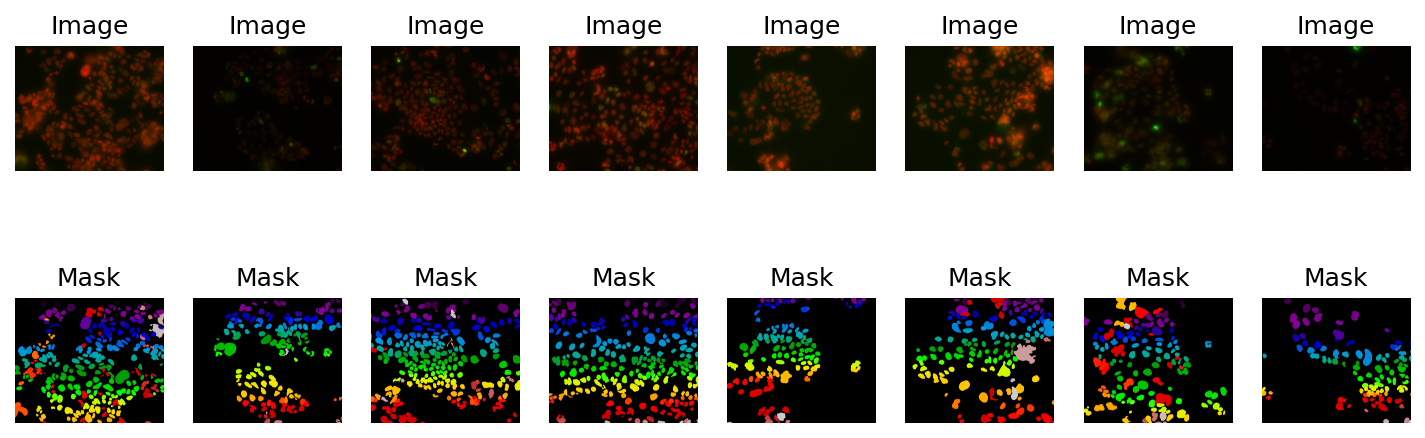

In [5]:
# %matplotlib inline
plt.figure(figsize=(12, 4), dpi=150)

for k, f in enumerate(train_files):
    # Load image
    img = io.imread(f)

    # Normalize image if needed
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        img /= img.max() if img.max() > 0 else 1  # scale to [0, 1]

    # Plot image
    plt.subplot(2, len(train_files), k + 1)
    img = np.vstack((img, np.zeros_like(img)[:1]))  # Optional: remove if not needed
    img = img.transpose(1, 2, 0) if img.ndim == 3 else img
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")

    # Load and plot mask
    plt.subplot(2, len(train_files), len(train_files) + k + 1)
    seg_path = os.path.splitext(f)[0] + '_seg.npy'
    seg = np.load(seg_path, allow_pickle=True).item()
    masks = seg['masks'].squeeze()
    plt.imshow(masks, cmap='nipy_spectral')  # color-coded mask
    plt.axis('off')
    plt.title("Mask")


# Train model on manual annotations

## Training parameters

<font size = 2> **Paths for training, predictions and results**


<font size = 2>**`train_dir:`, `test_dir`:** These are the paths to your folders train_dir (with images and masks of training images) and test_dir (with images and masks of test images).

<font size = 2>**`initial_model`:** Choose a model from the cellpose [model zoo](https://cellpose.readthedocs.io/en/latest/models.html#model-zoo) to start from.

<font size = 2>**`model_name`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 2>**Training parameters**

<font size = 2>**`number_of_epochs`:** Input how many epochs the network will be trained. At least 100 epochs are recommended, but sometimes 250 epochs are necessary, particularly from scratch. **Default value: 100**



In [6]:
train_dir = "train" 
test_dir = "test" 

#Define where the patch file will be saved
base = "cellpose"

# model name and path
from cellpose import models
initial_model = "nuclei" # ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "ddq_model_1"

# other parameters for training.
n_epochs =  100
Channel_to_use_for_training = "Red" # ["Grayscale", "Blue", "Green", "Red"]

# If you have a secondary channel that can be used for training, for instance nuclei, choose it here:
Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]

# Advanced Parameters
Use_Default_Advanced_Parameters = True
learning_rate = 0.1 
weight_decay = 0.0001 

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  learning_rate = 0.1
  weight_decay = 0.0001

#here we check that no model with the same name already exist, if so delete
model_path = 'custom_models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Default advanced parameters enabled


Here's what the command to train would be on the command line -- make sure if you run this locally to correct the paths for your local computer.

In [ ]:
run_str = f'python -m cellpose --use_gpu --verbose --train --dir {train_dir} --pretrained_model {initial_model} --chan {chan} --chan2 {chan2} --n_epochs {n_epochs} --learning_rate {learning_rate} --weight_decay {weight_decay}'
if test_dir is not None:
    run_str += f' --test_dir {test_dir}'
run_str += ' --mask_filter _seg.npy' # if you want to use _seg.npy files for training
print(run_str)

## Train new model

Using settings from form above, train model in notebook.

In [7]:
from cellpose import train

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg.npy')
train_data, train_labels, _, test_data, test_labels, _ = output

new_model_path, train_losses, test_losses = train.train_seg(model.net, train_data=train_data,
                              train_labels=train_labels,
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels,
                              save_path=model_path,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              SGD=True,
                              nimg_per_epoch=8,
                              model_name=model_name)

# diameter of labels in training images
diam_labels = model.net.diam_labels.item()

2025-10-03 16:07:56,883 [INFO] WRITING LOG OUTPUT TO /home/cse/.cellpose/run.log
2025-10-03 16:07:56,884 [INFO] 
cellpose version: 	3.1.1 
platform:       	linux 
python version: 	3.12.3 
torch version:  	2.8.0+cu128
2025-10-03 16:07:56,885 [INFO] >> nuclei << model set to be used
2025-10-03 16:07:56,887 [INFO] ** TORCH CUDA version installed and working. **
2025-10-03 16:07:56,889 [INFO] >>>> using GPU (CUDA)
2025-10-03 16:07:56,933 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-10-03 16:07:56,959 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-10-03 16:07:56,960 [INFO] not all flows are present, running flow generation for all images
2025-10-03 16:07:57,186 [INFO] 8 / 8 images in train folder have labels
2025-10-03 16:07:57,187 [INFO] not all flows are present, running flow generation for all images
2025-10-03 16:07:57,229 [INFO] 1 / 1 images in test folder have labels
2025-10-03 16:07:57,229 [INFO] computing flows for 

100%|██████████| 8/8 [00:13<00:00,  1.65s/it]

2025-10-03 16:08:10,433 [INFO] computing flows for labels


2025-10-03 16:08:12,662 [INFO] >>> computing diameters


100%|██████████| 1/1 [00:00<00:00, 92.96it/s]

2025-10-03 16:08:12,763 [INFO] >>> using channels [1, 0]
2025-10-03 16:08:12,764 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2025-10-03 16:08:13,553 [INFO] >>> n_epochs=100, n_train=8, n_test=1
2025-10-03 16:08:13,554 [INFO] >>> SGD, learning_rate=0.10000, weight_decay=0.00010, momentum=0.900
2025-10-03 16:08:13,999 [INFO] >>> saving model to custom_models/models/ddq_model_1
2025-10-03 16:08:14,522 [INFO] 0, train_loss=0.4424, test_loss=0.4307, LR=0.000000, time 0.52s
2025-10-03 16:08:15,955 [INFO] 5, train_loss=0.3337, test_loss=0.2330, LR=0.055556, time 1.96s
2025-10-03 16:08:17,369 [INFO] 10, train_loss=0.3046, test_loss=0.3006, LR=0.100000, time 3.37s
2025-10-03 16:08:20,163 [INFO] 20, train_loss=0.2507, test_loss=0.2328, LR=0.100000, time 6.16s
2025-10-03 16:08:23,050 [INFO] 30, train_loss=0.2326, test_loss=0.2152, LR=0.100000, time 9.05s
2025-10-03 16:08:25,800 [INFO] 40, train_loss=0.2514, test_loss=0.1799, LR=0.100000, time 11.80s
2025-10-03 16:08:28,661 [INFO] 50, train_loss=0.2159, test_loss=0.1783, LR=0.100000, time 14.66s
2025-10-03 16:08:31,419 [INFO] 60, train_loss=0.2225, test_loss=0.1663, LR=

## Evaluate on test data (optional)

If you have test data, check performance

In [8]:
# get files (during training, test_data is transformed so we will load it again)
output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
test_data, test_labels = output[:2]

# run model on test images
masks = model.eval(test_data,
                   channels=[chan, chan2],
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


2025-10-03 16:08:42,717 [INFO] not all flows are present, running flow generation for all images
2025-10-03 16:08:42,760 [INFO] 1 / 1 images in test folder have labels

>>> average precision at iou threshold 0.5 = 0.924


plot masks

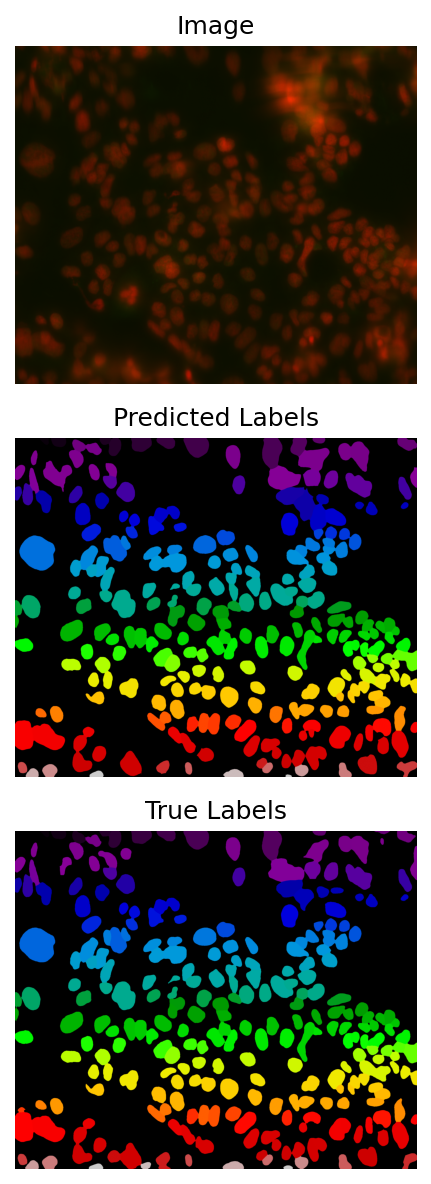

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8), dpi=150)

for k, im in enumerate(test_data):
    # Copy image and normalize if needed
    img = im.copy()
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        img /= img.max() if img.max() > 0 else 1  # Normalize to [0,1]

    # Optional padding (can remove if unnecessary)
    img = np.vstack((img, np.zeros_like(img)[:1]))

    # Transpose if in (C, H, W) format
    if img.ndim == 3 and img.shape[0] <= 4:
        img = img.transpose(1, 2, 0)

    # Plot original image
    plt.subplot(3, len(test_data), k + 1)
    plt.imshow(img)
    plt.axis('off')
    if k == 0:
        plt.title('Image')

    # Plot predicted mask
    plt.subplot(3, len(test_data), len(test_data) + k + 1)
    plt.imshow(masks[k], cmap='nipy_spectral')
    plt.axis('off')
    if k == 0:
        plt.title('Predicted Labels')

    # Plot ground truth
    plt.subplot(3, len(test_data), 2 * len(test_data) + k + 1)
    plt.imshow(test_labels[k], cmap='nipy_spectral')
    plt.axis('off')
    if k == 0:
        plt.title('True Labels')

plt.tight_layout()
plt.show()


# Use custom model to segment images

In [10]:
model_path = "custom_models/models/ddq_model_1"
image_dir = "test" 

# Channel Parameters:

Channel_to_use_for_segmentation = "Red" # ["Grayscale", "Blue", "Green", "Red"]
Second_segmentation_channel= "None" # ["None", "Blue", "Green", "Red"]

# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1

if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

# Segmentation parameters:
# diameter of cells (set to zero to use diameter from training set):
diameter =  0 # {type:"number"}

# threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 # {type:"slider", min:0.0, max:3.0, step:0.1}

# threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 # {type:"slider", min:-6, max:6, step:1}

In [ ]:
run_str = f'python -m cellpose --use_gpu --verbose --dir {image_dir} --pretrained_model {model_path} --chan {chan} --chan2 {chan2} --diameter {diameter} --flow_threshold {flow_threshold} --cellprob_threshold {cellprob_threshold}'
print(run_str)

## run custom model

In [11]:
# gets image files in dir (ignoring image files ending in _masks)
# get all .tif files
all_tifs = natsorted(glob(os.path.join(image_dir, '*.tif')))

# exclude any prediction masks
files = [f for f in all_tifs if not f.endswith('_cp_masks.tif')]
print(files)
images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=True,
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images,
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )

['test/4Gy_53BP1_8Hr.tif']
2025-10-03 16:08:47,359 [INFO] ** TORCH CUDA version installed and working. **
2025-10-03 16:08:47,359 [INFO] >>>> using GPU (CUDA)
2025-10-03 16:08:47,388 [INFO] >>>> loading model custom_models/models/ddq_model_1
2025-10-03 16:08:47,412 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-10-03 16:08:47,412 [INFO] >>>> model diam_labels =  85.466 (mean diameter of training ROIs)


## save output to *_seg.npy

you will see the files save in the Files tab and you can download them from there

## save output masks to tiffs/pngs or txt files for imageJ

In [12]:
io.save_masks(images,
              masks,
              flows,
              files,
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=True, # save outlines as TIFFs
              save_mpl=False, # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
              
              )

In [ ]:
files[0]

## .npy visualization

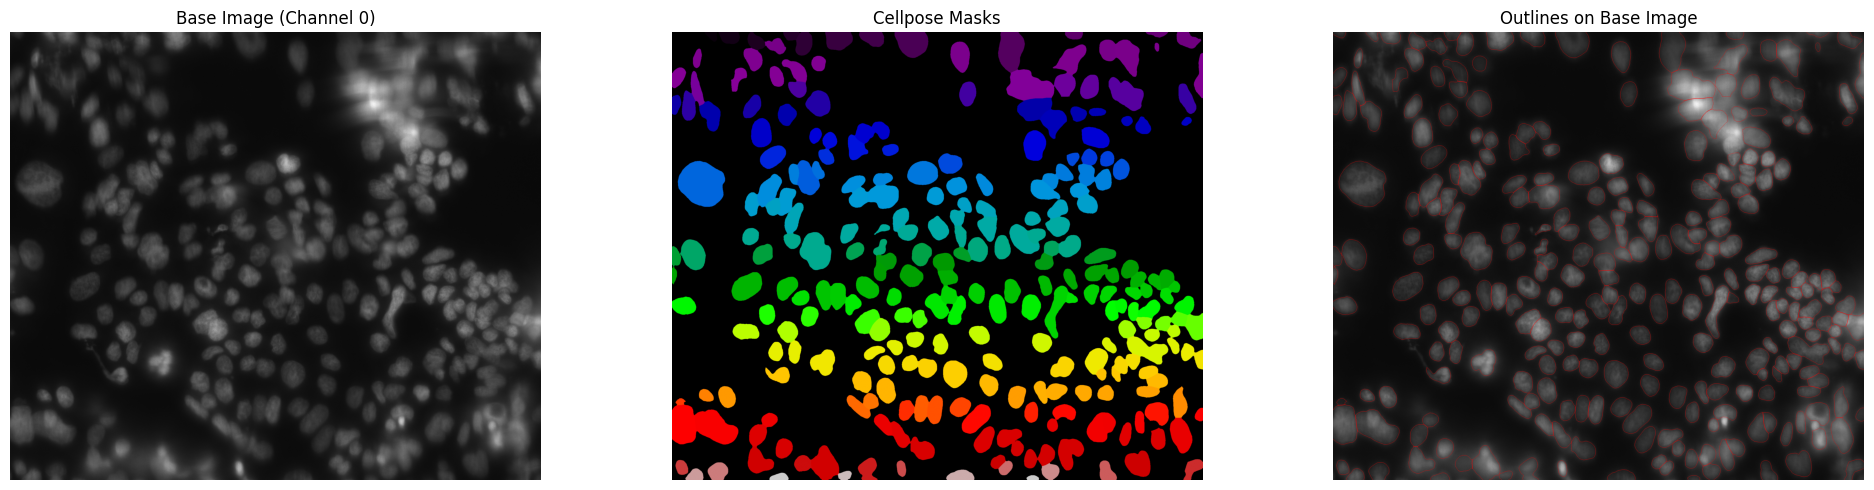

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.segmentation import find_boundaries
from cellpose import plot

# Load TIFF image
img_name = 'test/4Gy_53BP1_8Hr'
img = imread(f'{img_name}.tif')

# Handle (C, H, W) TIFFs
if img.ndim == 3 and img.shape[0] <= 4:
    img = np.moveaxis(img, 0, -1)

# At this point img shape = (H, W, 2)
H, W, C = img.shape
assert C == 2, f"Expected 2 channels, got {C}"

# Use first channel (e.g., blue = nuclei) as grayscale base for visualization
base_img = img[..., 0]  # or img[..., 1] if you prefer green

# Normalize if needed
if base_img.max() > 255:
    base_img = (base_img / base_img.max() * 255).astype(np.uint8)
else:
    base_img = base_img.astype(np.uint8)

# Convert to RGB (grayscale stacked 3 times)
img_rgb = np.stack([base_img] * 3, axis=-1)  # shape (H, W, 3)

# Load Cellpose outputs
seg_data = np.load(f'{img_name}_seg.npy', allow_pickle=True).item()
masks = seg_data['masks']
flows = seg_data['flows']
# flow_y, flow_x = flows[:2]

# Generate boundaries (outlines)
outlines = find_boundaries(masks, mode='inner')  # Generates boolean mask of boundaries

# Draw red outlines on the image
img_outline = img_rgb.copy()
img_outline[outlines] = np.array([255, 0, 0], dtype=np.uint8)  # Red color for outlines

# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot the original base image
axs[0].imshow(img_rgb)
axs[0].set_title("Base Image (Channel 0)")
axs[0].axis('off')

# Plot the Cellpose masks
axs[1].imshow(masks, cmap='nipy_spectral')
axs[1].set_title("Cellpose Masks")
axs[1].axis('off')

# Plot the outlines on the original image
imsave(f'{img_name}_outline.png',img_outline)
axs[2].imshow(img_outline)
axs[2].set_title("Outlines on Base Image")
axs[2].axis('off')


plt.tight_layout()
plt.show()


 COMPREHENSIVE CELL COUNTING ANALYSIS
1️ GROUND TRUTH CELL COUNTS (_seg.npy files):
   4Gy_53BP1_8Hr: 269 cells

2️ GENERATED MASK CELL COUNTS (cp_masks.tif files):
   4Gy_53BP1_8Hr: 264 cells

3️ CELLPOSE 3.1.1 LIVE ANALYSIS (.tif images):
🔄 Creating Cellpose model (one-time setup)...
2025-10-03 16:08:53,232 [INFO] ** TORCH CUDA version installed and working. **
2025-10-03 16:08:53,233 [INFO] >>>> using GPU (CUDA)
2025-10-03 16:08:53,233 [INFO] >> nuclei << model set to be used
2025-10-03 16:08:53,257 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-10-03 16:08:53,281 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
✅ Cellpose model created and cached
2025-10-03 16:08:53,289 [INFO] channels set to [0, 0]
2025-10-03 16:08:53,289 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2025-10-03 16:08:54,714 [INFO] estimated cell diameter(s) in 1.43 sec
2025-10-03 16:08:54,715 [INFO] >>> diameter(s) = 
2025-10-03 16:08:54,715 [INFO] [ 64.12 ]


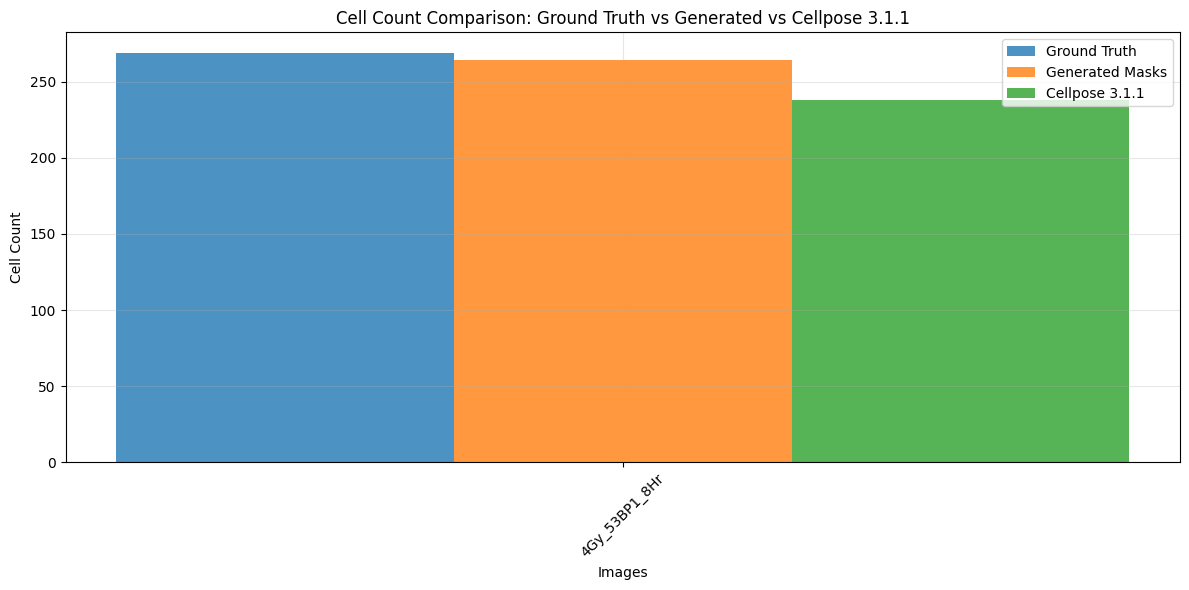

 Bar chart visualization created above!

 Cell counting analysis completed!


In [14]:
#  CELL COUNTING COMPARISON: Ground Truth vs Generated vs Cellpose 3.1.1
import numpy as np
import matplotlib.pyplot as plt
from cellpose import io, models
import os
from glob import glob
from natsort import natsorted

print(" COMPREHENSIVE CELL COUNTING ANALYSIS")
print("=" * 70)

# 1. Count cells in ground truth (_seg.npy files)
print("1️ GROUND TRUTH CELL COUNTS (_seg.npy files):")
gt_seg_files = natsorted(glob('test/*_seg.npy'))
gt_counts = {}

for seg_file in gt_seg_files:
    img_name = os.path.basename(seg_file).replace('_seg.npy', '')
    seg_data = np.load(seg_file, allow_pickle=True).item()
    masks = seg_data['masks']
    cell_count = len(np.unique(masks)) - 1  # Subtract 1 for background
    gt_counts[img_name] = cell_count
    print(f"   {img_name}: {cell_count} cells")

# 2. Count cells in generated masks (cp_masks.tif files)
print(f"\n2️ GENERATED MASK CELL COUNTS (cp_masks.tif files):")
cp_mask_files = natsorted(glob('test/*cp_masks.tif'))
generated_counts = {}

for mask_file in cp_mask_files:
    img_name = os.path.basename(mask_file).replace('_cp_masks.tif', '')
    masks = io.imread(mask_file)
    cell_count = len(np.unique(masks)) - 1  # Subtract 1 for background
    generated_counts[img_name] = cell_count
    print(f"   {img_name}: {cell_count} cells")

# 3. Run Cellpose 3.1.1 on original TIFF images and count cells
print(f"\n3️ CELLPOSE 3.1.1 LIVE ANALYSIS (.tif images):")
tif_files = natsorted(glob('test/*.tif'))
# Filter out cp_masks.tif files to only process original images
tif_files = [f for f in tif_files if not f.endswith('cp_masks.tif')]
cellpose_counts = {}

# Load Cellpose nuclei model (avoid repeated downloads)
if 'cellpose_model_cached' not in globals():
    print("🔄 Creating Cellpose model (one-time setup)...")
    cellpose_model_cached = models.Cellpose(gpu=True, model_type='nuclei')
    print("✅ Cellpose model created and cached")
else:
    print("✅ Using cached Cellpose model (no download needed)")

for tif_file in tif_files:
    img_name = os.path.basename(tif_file).replace('.tif', '')
    
    # Load image
    img = io.imread(tif_file)
    
    # Run Cellpose
    masks, flows, styles, diams = cellpose_model_cached.eval(img, diameter=None, channels=[0,0])
    cell_count = len(np.unique(masks)) - 1  # Subtract 1 for background
    cellpose_counts[img_name] = cell_count
    print(f"   {img_name}: {cell_count} cells")

# 4. Create comparison summary
print(f"\n CELL COUNT COMPARISON SUMMARY:")
print("=" * 70)
print(f"{'Image Name':<25} {'Ground Truth':<12} {'Generated':<12} {'Cellpose 3.1.1':<15}")
print("-" * 70)

all_images = set(gt_counts.keys()) | set(generated_counts.keys()) | set(cellpose_counts.keys())

total_gt = 0
total_generated = 0
total_cellpose = 0

for img_name in sorted(all_images):
    gt = gt_counts.get(img_name, 'N/A')
    gen = generated_counts.get(img_name, 'N/A')
    cp = cellpose_counts.get(img_name, 'N/A')
    
    print(f"{img_name:<25} {str(gt):<12} {str(gen):<12} {str(cp):<15}")
    
    # Add to totals if numeric
    if isinstance(gt, int): total_gt += gt
    if isinstance(gen, int): total_generated += gen
    if isinstance(cp, int): total_cellpose += cp

print("-" * 70)
print(f"{'TOTAL':<25} {total_gt:<12} {total_generated:<12} {total_cellpose:<15}")


# 6. Optional: Create a visualization
if len(all_images) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x_pos = np.arange(len(all_images))
    width = 0.25
    
    # Prepare data for plotting
    gt_vals = [gt_counts.get(img, 0) for img in sorted(all_images)]
    gen_vals = [generated_counts.get(img, 0) for img in sorted(all_images)]
    cp_vals = [cellpose_counts.get(img, 0) for img in sorted(all_images)]
    
    # Create bars
    ax.bar(x_pos - width, gt_vals, width, label='Ground Truth', alpha=0.8)
    ax.bar(x_pos, gen_vals, width, label='Generated Masks', alpha=0.8)
    ax.bar(x_pos + width, cp_vals, width, label='Cellpose 3.1.1', alpha=0.8)
    
    # Customize plot
    ax.set_xlabel('Images')
    ax.set_ylabel('Cell Count')
    ax.set_title('Cell Count Comparison: Ground Truth vs Generated vs Cellpose 3.1.1')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([img[:15] + '...' if len(img) > 15 else img for img in sorted(all_images)], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(" Bar chart visualization created above!")

print("\n Cell counting analysis completed!")